# Quering the OSRM API using Python: Part 1

## Introduction

Basic querying of OSRM is not so difficult, as long as you follow the [documentation](https://project-osrm.org/docs/v5.24.0/api/).

We'll be using Python in this tutorial. There’s a Python wrapper called *python-osrm*, however, instead of the wrapper, we’ll be using our old friend, the “requests” library.

As per the documentation, the services that OSRM provides are:

- **Nearest**: snaps a coordinate to the street network and returns the nearest n matches.

- **Route**: finds the fastest route between coordinates in the supplied order.

- **Table**: computes the duration of the fastest route between all pairs of supplied coordinates. The output can be interpreted as a time/distance matrix.

- **Match**: "map matching" or snaps given GPS points to the road network in the most plausible way. Very useful to consolidate noisy data.

- **Trip**: solves the Traveling Salesman Problem.

- **Tile**: generates Mapbox Vector Tiles that can be viewed with a web map.


This tutorial will be centered on the route, nearest and table services.

Using the **requests** library we can query the API and retrieve the results. Once we have done that, we will handle the result in order to transform the output dictionary into a different format, like a pandas’ DataFrame or a Geopandas’ GeoDatFrame, that then we can export and visualize in QGIS, among many other uses.

Remember to have the OSRM docker container running in the background (if you're using Windows, execute the Docker Desktop app). However, if you can’t do this or you are not interested in doing this, you can use the OSRM demo backend in this URL: https://routing.openstreetmap.de/routed-car/route/v1/driving/

We'll be using the previously created container, which has network data for the country of Malta, provided by Geofabrik as a PBF file.


Create a virtual environment and install all the dependencies in the `requirements.txt` file.

```bash
# create a virtual environment
python -m venv venv

# activate the virtual environment
source venv/bin/activate

# install the dependencies
pip install -r requirements.txt
```

## Services offered by OSRM



First, we'll be reviewing the [route service](https://project-osrm.org/docs/v5.24.0/api/#route-service) in OSRM. We'll be using the Python library `requests` to query the service.


We can send the requests with the .get() method, which returns the response as a Python dictionary.

The *requests* library has a [built-in method](https://requests.readthedocs.io/en/latest/user/quickstart/#json-response-content) to convert the response to JSON, which we can use to parse the response.

In [1]:
import requests
from requests.exceptions import HTTPError
import json
import numpy as np
from shapely.geometry import LineString, Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import leafmap

### The route service

Finds the fastest route between coordinates in the supplied order.

In [2]:
# URL for the OSRM server
HOST = "http://127.0.0.1:5000/" # change whatever your server is hosted
URL = HOST + "route/v1/driving/14.5035,35.8976;14.5144,35.8989?overview=full&geometries=geojson"

response = requests.get(URL)

# Print the status code of the response
print(response.status_code)

r = response.json()

print(r)

print(json.dumps(r, indent=2))

200
{'code': 'Ok', 'routes': [{'geometry': {'coordinates': [[14.503506, 35.897214], [14.503517, 35.897182], [14.50354, 35.897128], [14.503567, 35.897066], [14.503521, 35.897022], [14.503214, 35.896814], [14.503173, 35.896765], [14.503153, 35.896676], [14.503183, 35.896586], [14.503907, 35.896721], [14.504449, 35.896815], [14.504652, 35.896775], [14.505035, 35.89663], [14.505132, 35.896582], [14.505231, 35.896467], [14.505401, 35.896375], [14.505526, 35.896346], [14.505631, 35.896338], [14.505664, 35.896346], [14.505876, 35.89641], [14.506003, 35.896414], [14.506087, 35.896387], [14.506102, 35.89636], [14.506116, 35.896321], [14.506134, 35.896271], [14.506164, 35.896172], [14.506251, 35.895861], [14.5063, 35.895716], [14.506342, 35.895545], [14.506353, 35.895495], [14.506341, 35.895444], [14.506379, 35.895352], [14.506443, 35.895151], [14.506456, 35.895105], [14.506545, 35.89496], [14.506569, 35.894908], [14.506697, 35.894707], [14.506795, 35.894569], [14.50683, 35.894521], [14.506881, 

According to the documentation, the response from the route service contains the following keys:

- **code**: if the request was successful Ok otherwise see the service dependent and general status codes.

- **waypoints**: Array of Waypoint objects representing all waypoints in order:

- **routes**: An array of Route objects, ordered by descending recommendation rank

In [3]:
print(r.keys())

dict_keys(['code', 'routes', 'waypoints'])


Let's extract the coordinates from the first route, so we create a list of lists, where each sub-list contains the coordinates of a point on the route.

Then we can proceed to create a shapely LineString object from the list of coordinates, that will be stored inside a Python list.

This LineString will be used to populate geometry of the Geopandas' GeoDataFrame. We'll plot the GeoDataFrame using matplotlib.

In [4]:
coords = r['routes'][0]['geometry']['coordinates']
print(coords[:5])

route_geom = [LineString(coords)]

print(route_geom)

gdf = gpd.GeoDataFrame(geometry=route_geom, crs=4326)

print(gdf)

[[14.503506, 35.897214], [14.503517, 35.897182], [14.50354, 35.897128], [14.503567, 35.897066], [14.503521, 35.897022]]
[<LINESTRING (14.504 35.897, 14.504 35.897, 14.504 35.897, 14.504 35.897, 14....>]
                                            geometry
0  LINESTRING (14.50351 35.89721, 14.50352 35.897...


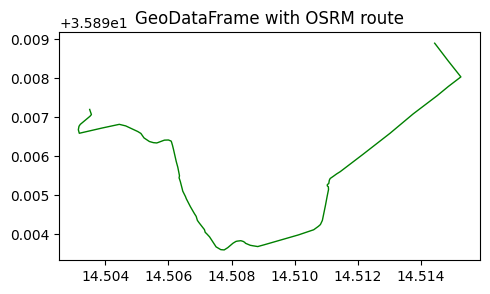

In [5]:
# plot
def plot_route(gdf):
    figsize=(5, 3)
    _, ax = plt.subplots(figsize=figsize)
    gdf.plot(ax=ax, color='green', linewidth=1)
    ax.set_title('GeoDataFrame with OSRM route')
    plt.tight_layout()
    plt.show()

plot_route(gdf)

In [6]:
route_geom

[<LINESTRING (14.504 35.897, 14.504 35.897, 14.504 35.897, 14.504 35.897, 14....>]

We can also use leafmap to visualize the results of the routing query.

In [ ]:
center = [route_geom[0].centroid.y, route_geom[0].centroid.x]

m = leafmap.Map(center = center, zoom=15,)

style = {
    "stroke": True,
    "color": "#e40fb6",
    "weight": 4,
    "opacity": 0.8,
    "fill": False,
}

m.add_gdf(gdf, layer_name="Test route", style=style)
m

Map(center=[35.89582304887716, 14.509296020767042], controls=(ZoomControl(options=['position', 'zoom_in_text',…

And what if we want to repeat the same query but with different parameters?

We can do a simple for loop to do this. Eventually, we may use parallelization to speed up the process, but this is not the focus of this tutorial.

Sending request to http://127.0.0.1:5000//route/v1/driving/14.5144,35.8989;14.4032,35.8858?overview=full&geometries=geojson


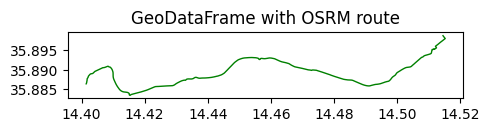

Success!
Sending request to http://127.0.0.1:5000//route/v1/driving/14.5028,35.9128;14.3336,36.0751?overview=full&geometries=geojson


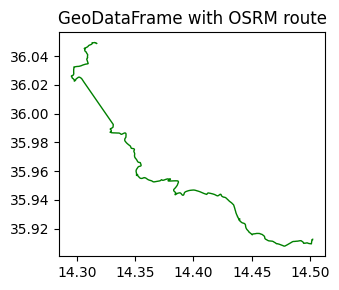

Success!
Sending request to http://127.0.0.1:5000//route/v1/driving/14.4775,35.8574;14.4887,35.9196;14.3621,35.9524?overview=full&geometries=geojson


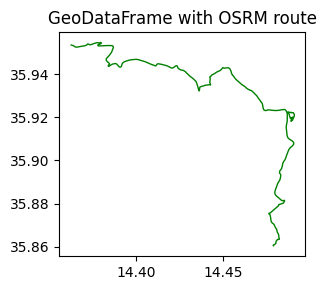

Success!


In [8]:
coordinates = [
    '14.5144,35.8989;14.4032,35.8858',
    '14.5028,35.9128;14.3336,36.0751',
    '14.4775,35.8574;14.4887,35.9196;14.3621,35.9524'
    ]

URLS = [f"{HOST}/route/v1/driving/{c}?overview=full&geometries=geojson" for c in coordinates]

for url in URLS:
    try:
        print(f"Sending request to {url}")
        response = requests.get(url)
        response.raise_for_status()
        r = response.json()
        coords = r['routes'][0]['geometry']['coordinates']
        route_geom = [LineString(coords)]
        gdf = gpd.GeoDataFrame(geometry=route_geom, crs=4326)
        plot_route(gdf)
    except HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    else:
        print("Success!")

### The nearest service

Snaps a coordinate to the street network and returns the nearest n matches.

In [9]:
URL = HOST + 'nearest/v1/driving/14.5144,35.8989?number=1'

response = requests.get(URL)
response.raise_for_status()
r = response.json()

# Extract snapped points
snapped_points = [
    Point(waypoint["location"][0], waypoint["location"][1])
    for waypoint in r["waypoints"]
]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=snapped_points, crs="EPSG:4326")
print(gdf)

                    geometry
0  POINT (14.51442 35.89891)


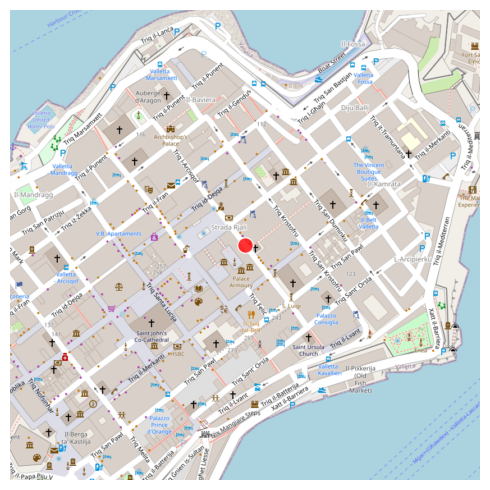

In [10]:
gdf_mercator = gdf.to_crs(epsg=3857)

def plot_pts(input_gdf, buffer=500):
    ax = input_gdf.plot(
    figsize=(5, 5),
    markersize=125,          # Larger points
    color="red",           # Bold color
    edgecolor="white",     # Contrast border
    alpha=0.8,            # Slightly transparent
    linewidth=1           # Border thickness
    )

    buffer = 500  # meters (adjust based on desired zoom)
    x_min, y_min, x_max, y_max = input_gdf.total_bounds
    ax.set_xlim(x_min - buffer, x_max + buffer)
    ax.set_ylim(y_min - buffer, y_max + buffer)


    # Add high-resolution basemap with proper zoom
    cx.add_basemap(
        ax,
        source=cx.providers.OpenStreetMap.Mapnik,  # High-quality OSM
        attribution=False                          # Optional: hide attribution
    )

    # Improve margins and axis visibility
    ax.set_axis_off()  # Cleaner look (no axes)
    plt.tight_layout()  # Prevent cropping
    plt.show()

plot_pts(gdf_mercator)

                    geometry
0   POINT (14.47844 35.8603)
1  POINT (14.47862 35.86039)
2  POINT (14.47872 35.86046)


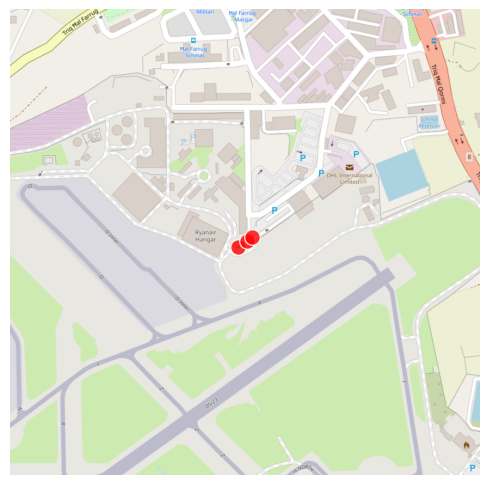

In [11]:
URL = HOST + 'nearest/v1/driving/14.4775,35.8574?number=3'

response = requests.get(URL)
response.raise_for_status()
r = response.json()

# Extract snapped points
snapped_points = [
    Point(waypoint["location"][0], waypoint["location"][1])
    for waypoint in r["waypoints"]
]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=snapped_points, crs="EPSG:4326")
print(gdf)

gdf_mercator = gdf.to_crs(epsg=3857)

plot_pts(gdf_mercator)

### The table service

Computes the duration of the fastest route between all pairs of supplied coordinates. The output can be interpreted as a time/distance matrix.

In [12]:
URL = HOST + 'table/v1/driving/14.5144,35.8989;14.5028,35.9128;14.4775,35.8574?annotations=duration,distance'

In [13]:
response = requests.get(URL)
response.raise_for_status()
r = response.json()

# Extract matrix
durations = r["durations"]  # Time matrix (seconds)
distances = r["distances"]  # Distance matrix (meters)

print("Durations (s):", durations)
print("Distances (m):", distances)

Durations (s): [[0, 666.9, 661.3], [634.9, 0, 802.9], [601.3, 792, 0]]
Distances (m): [[0, 6407.1, 7299.8], [6579.5, 0, 8551.3], [6899.4, 8558, 0]]


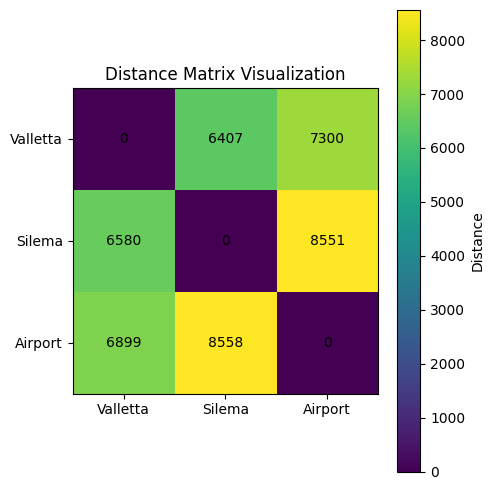

In [14]:
# Labels for the rows and columns
labels = ['Valletta', 'Silema', 'Airport']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap using imshow
cax = ax.imshow(distances, cmap='viridis', interpolation='nearest')

# Add colorbar for reference
cbar = fig.colorbar(cax)
cbar.set_label('Distance')

# Set ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Loop over data to create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{np.array(distances)[i, j]:.0f}",
                ha="center", va="center", color="black")

# Add title and labels
plt.title("Distance Matrix Visualization")

# Show the plot
plt.tight_layout()
plt.show()

### Match service

Performs "map matching"... or snaps given GPS points to the road network in the most plausible way.

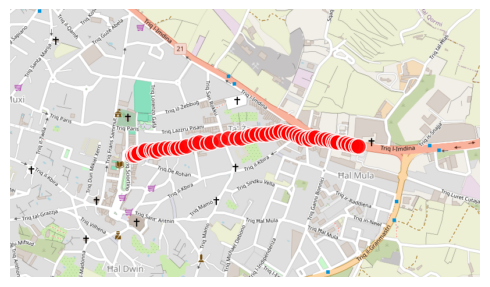

In [15]:
gps_mock_data = [
    [35.87326, 14.44199],
    [35.87332, 14.44206],
    [35.87327, 14.44209],
    [35.87333, 14.44219],
    [35.87334, 14.44224],
    [35.8734, 14.44243],
    [35.87343, 14.44248],
    [35.87341, 14.44271],
    [35.87341, 14.44279],
    [35.8734, 14.4429],
    [35.87344, 14.443],
    [35.87347, 14.44322],
    [35.87348, 14.44339],
    [35.87348, 14.44358],
    [35.87348, 14.44366],
    [35.87351, 14.44385],
    [35.87355, 14.44401],
    [35.87362, 14.44433],
    [35.87365, 14.44447],
    [35.87364, 14.44476],
    [35.87366, 14.44491],
    [35.87372, 14.44524],
    [35.87377, 14.44554],
    [35.87378, 14.44585],
    [35.87378, 14.44603],
    [35.87384, 14.44627],
    [35.87388, 14.4464],
    [35.87389, 14.44659],
    [35.87389, 14.44679],
    [35.87389, 14.44694],
    [35.87394, 14.44715],
    [35.87396, 14.44731],
    [35.87398, 14.44747],
    [35.87396, 14.44763],
    [35.87394, 14.44777],
    [35.87392, 14.44794],
    [35.87388, 14.44807],
    [35.87383, 14.44818],
    [35.87379, 14.44829],
    [35.87377, 14.44842],
    [35.87376, 14.44855],
    [35.8738, 14.44864],
    [35.8738, 14.44875],
    [35.87376, 14.44902],
    [35.87374, 14.44911],
    [35.87372, 14.44927],
    [35.87369, 14.44942],
    [35.87367, 14.44949],
    [35.87365, 14.44958],
    [35.87362, 14.44981],
    [35.87362, 14.44987],
    [35.87359, 14.44997],
    [35.87356, 14.45011],
    [35.87354, 14.45026],
    [35.87354, 14.45035]
]

geometry = [Point(lon, lat) for lat, lon in gps_mock_data]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

gdf_mercator = gdf.to_crs(epsg=3857)

plot_pts(gdf_mercator, buffer=10)

In [16]:
base_url = HOST + "match/v1/driving/"
coordinates = "14.44199,35.87326;14.44206,35.87332;14.44209,35.87327;14.44219,35.87333;14.44224,35.87334;14.44243,35.8734;14.44248,35.87343;14.44271,35.87341;14.44279,35.87341;14.4429,35.8734;14.443,35.87344;14.44322,35.87347;14.44339,35.87348;14.44358,35.87348;14.44366,35.87348;14.44385,35.87351;14.44401,35.87355;14.44433,35.87362;14.44447,35.87365;14.44476,35.87364;14.44491,35.87366;14.44524,35.87372;14.44554,35.87377;14.44585,35.87378;14.44603,35.87378;14.44627,35.87384;14.4464,35.87388;14.44659,35.87389;14.44679,35.87389;14.44694,35.87389;14.44715,35.87394;14.44731,35.87396;14.44747,35.87398;14.44763,35.87396;14.44777,35.87394;14.44794,35.87392;14.44807,35.87388;14.44818,35.87383;14.44829,35.87379;14.44842,35.87377;14.44855,35.87376;14.44864,35.8738;14.44875,35.8738;14.44902,35.87376;14.44911,35.87374;14.44927,35.87372;14.44942,35.87369;14.44949,35.87367;14.44958,35.87365;14.44981,35.87362;14.44987,35.87362;14.44997,35.87359;14.45011,35.87356;14.45026,35.87354;14.45035,35.87354"

coord_str = [f'{lon},{lat}' for lat, lon in gps_mock_data]
coordinates = ';'.join(coord_str)

URL = f"{base_url}{coordinates}?overview=full&geometries=geojson"

response = requests.get(URL)
response.raise_for_status()
r = response.json()
r

{'code': 'Ok',
 'matchings': [{'confidence': 0,
   'geometry': {'coordinates': [[14.441992, 35.873347],
     [14.442061, 35.873346],
     [14.442092, 35.873346],
     [14.44219, 35.873344],
     [14.442206, 35.873344],
     [14.442239, 35.873347],
     [14.442407, 35.873361],
     [14.442437, 35.873365],
     [14.442491, 35.873372],
     [14.442712, 35.873399],
     [14.44279, 35.873409],
     [14.442896, 35.873422],
     [14.443001, 35.873435],
     [14.443141, 35.873453],
     [14.443221, 35.873462],
     [14.44339, 35.873481],
     [14.443576, 35.873501],
     [14.443593, 35.873503],
     [14.443654, 35.873511],
     [14.443846, 35.873534],
     [14.443887, 35.873539],
     [14.44401, 35.873551],
     [14.444318, 35.873581],
     [14.444336, 35.873583],
     [14.444479, 35.873599],
     [14.444762, 35.87363],
     [14.444912, 35.873647],
     [14.445246, 35.873684],
     [14.44542, 35.873703],
     [14.445548, 35.873719],
     [14.445548, 35.873719],
     [14.445855, 35.873752],
   

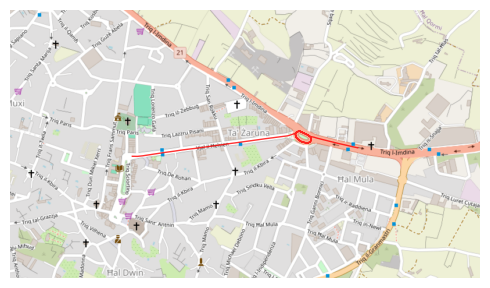

In [17]:
matched = r["matchings"][0]["geometry"]["coordinates"]

geometry = [LineString(matched)]

# Converts to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

gdf_mercator = gdf.to_crs(epsg=3857)

plot_pts(gdf_mercator, buffer=10)

Or, again, lets use leafmap to plot the route:

In [18]:
center = [geometry[0].centroid.y, geometry[0].centroid.x]

m = leafmap.Map(center = center, zoom=16, height="400", width="600")

style = {
    "stroke": True,
    "color": "#1b91c7",
    "weight": 4,
    "opacity": 0.8,
    "fill": False,
}

m.add_gdf(gdf, layer_name="Test route", style=style)
m

Map(center=[35.873779418087246, 14.44692324612555], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Conclusion

We tested 4 of the routing services offered by OSRM. We also developed code to query the OSRM API and plot the results, code that can be easily modified to query other routing services.

In next notebooks, we'll be exploring other services and alternative routing engines.